In [1]:
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.utilities           import percentError
from pybrain.datasets import SupervisedDataSet
from pybrain.datasets            import ClassificationDataSet
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import tree
import getfeat
%matplotlib inline

In [58]:
def part(Y,partition):
    
    Y_q=np.zeros(len(Y))
    i=0
    for y in Y:
        k=0
        score=-1
        for p in partition:
            if y in p:
                score=k
                break
            k+=1
        if score==-1:
            score=len(partition)
        Y_q[i]=score
        i+=1
    return Y_q

In [3]:
Q=getfeat.get_composed_feat_1h()

[[0], [1], [2, 3], [4, 5]]


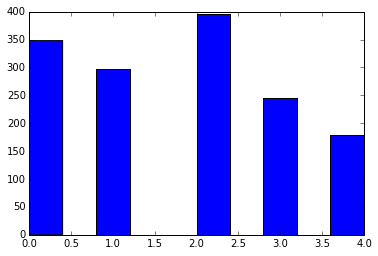

[[0], [1, 2], [3, 4]]


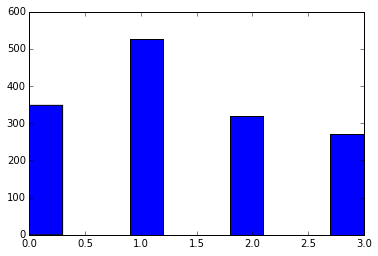

[[0, 1], [2, 3]]


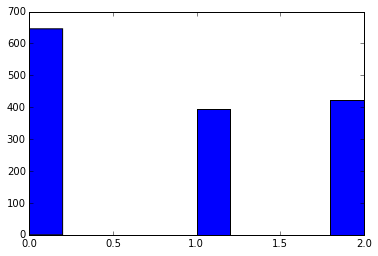

In [17]:
partitions1=[[[0],[1],[2,3],[4,5]],
             [[0],[1,2],[3,4]],
             [[0,1],[2,3]]
            ]
Y=Q[1]
for partition in partitions1:
    print partition
    Y_q=part(Y,partition)
    plt.hist(Y_q)
    plt.show()

In [18]:
Q=getfeat.get_composed_feat_h(2)

(10, 732)


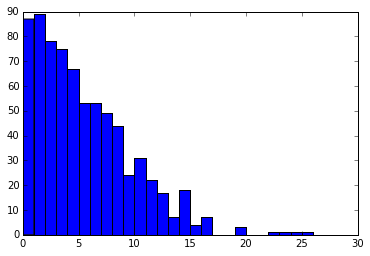

In [25]:
plt.hist(Y, list(range(int(max(Y)+1))))
plt.show()

In [146]:
partitions1=[[[0],[1],[2,3],[4,5]],
             [[0],[1,2],[3,4]],
             [[0,1],[2,3]]
            ]
Partitions=[partitions1]
for j in [2,3,4,5,6]:
    Q=getfeat.get_composed_feat_h(j)
    Y=Q[1]
    H=np.histogram(Y,list(range(int(max(Y))+1)))
    partitions=[]
    start=1
    partition=[[0]]
    for c in range(3):
        s=0
        for i in range(start,len(H[0])):
            s+=H[0][i]
            if s>len(Y)/5:
                break
        partition.append(list(range(start,i+1)))
        start=i+1
    partitions.append(partition)

    for D in [5,4,3]:
        start=0
        partition=[]
        for c in range(D-1):
            s=0
            for i in range(start,len(H[0])):
                s+=H[0][i]
                if s>len(Y)/float(D):
                    break
            partition.append(list(range(start,i+1)))
            start=i+1
        partitions.append(partition)
    Partitions.append(partitions)

(10, 732)
(10, 488)
(10, 366)
(10, 293)
(10, 244)


In [154]:
len(X[0])

1321

In [151]:
n_feat=1321
n_est=200
klf=tree.DecisionTreeClassifier(max_depth=9)
clfs=[tree.DecisionTreeClassifier(),tree.DecisionTreeClassifier(min_samples_split=16),tree.DecisionTreeClassifier(max_depth=6)]
clfs+=[RandomForestClassifier(n_estimators=n_est, max_features=i,max_depth=9) for i in range(1,n_feat)]
clfs+=[BaggingClassifier(base_estimator=klf,max_features=i,n_estimators=n_est) for i in range(1,n_feat)]
clfs+=[GradientBoostingClassifier(n_estimators=n_est, learning_rate=1.0,max_depth=9, random_state=0)]
clfs+=[AdaBoostClassifier(base_estimator=klf)]

In [152]:
names=['tree','tree_min_slit_16','tree_max_depth_6']
names+=['RandomForest_'+str(i)+'_f' for i in range(1,n_feat)]
names+=['Bagging_'+str(i)+'_f' for i in range(1,n_feat)]
names+=['GradientBoosting']
names+=['AdaBoost']

In [153]:
test_sizes=[120,70,50,35,30,25]

In [ ]:
filename='prova'
filename_c='provac'
f=open(filename,'a')
f.write('n_classf;name_classf;h_aggregation;risk_bands;features;avg_distance_from_true;std_distance_from_true;accuracy;recalls;precisions\n')
f.close
f=open(filename_c,'a')
f.write('n_classf;name_classf;h_aggregation;risk_bands;features;confusion\n')
f.close
for aggr in range(1,7):
    test_size=test_sizes[aggr-1]
    if aggr==1:
        Q=getfeat.get_composed_feat_1h()
    else:
        Q=getfeat.get_composed_feat_h(aggr)
    X=Q[0].T
    Y=Q[1]
    for partition in Partitions[aggr-1]:
        Y_q=part(Y,partition)
        features=list(range(n_feat))
        #for i in range(len(clfs)):
        for i in range(10):
            if i in [0,1,2]:
                for f in features:
                    res=evaluate_clf(clfs[i],X,Y_q,[f],test_size)
                    writeout(res,partition,aggr,[f],names,filename,i)
                    writeout_c(res[-1],partition,aggr,[f],names,filename_c,i)
            else:
                res=evaluate_clf(clfs[i],X,Y_q,features,test_size)
                writeout(res,partition,aggr,features,names,filename,i)
                writeout_c(res[-1],partition,aggr,features,names,filename_c,i)

In [165]:
def evaluate_clf(clf,X,Y_q,features,test_size):
    I=np.random.permutation(len(X))
    M=[]
    S=[]
    Acc=[]
    P=[]
    R=[]
    Conf=[]
    for i in range(len(X)/test_size-1):
        I_te=list(range(test_size*i,test_size*(i+1)))
        I_tr=list(range(0,test_size*i))+list(range(test_size*(i+1),len(I)))
        train=I[I_tr]
        test=I[I_te]

        XX = np.array([d[features] for d in X[train]])
        y=Y_q[train] 
        clf = clf.fit(XX, y)
        true=np.array([int(Y_q[t]) for t in test])
        pred=np.array([int(clf.predict([X[t][features]])[0]) for t in test])
        conf=confusion_matrix(true,pred) 
        recall=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[i,:]) for i in range(len(conf[:,0]))]
        precision=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[:,i]) for i in range(len(conf[:,0]))]
        
        Conf.append(conf)
        M.append(np.average(np.abs(true-pred)))
        S.append(np.std(true-pred))
        Acc.append(accuracy_score(true,pred))
        R.append(recall)
        P.append(precision)
    return[M,S,Acc,R,P,Conf]

In [169]:
def writeout(res,partition,aggr,features,names,filename,i):
    f=open(filename,'a')
    f.write(str(i)+';'+names[i]+';'+str(aggr)+';'+str(partition)+';'+str(features)+';'+str(res[0])+';'+str(res[1])+';'+str(res[2])+';'+str(res[3])+';'+str(res[4])+';\n')
    f.close
def writeout_c(conf,partition,aggr,features,names,filename,i):
    f=open(filename,'a')
    f.write(str(i)+';'+names[i]+';'+str(aggr)+';'+str(partition)+';'+str(features)+';\n')
    f.write(str(conf)+'\n')
    f.close

In [ ]:
'n_classf;name_classf;h_aggregation;risk_bands;features;avg_distance_from_true;std_distance_from_true;accuracy;recalls;precisions\n'
'n_classf;name_classf;h_aggregation;risk_bands;features;confusion\n'